In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

# Project 2
## Candidates 15908 & 15907

### (Short intro?)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from astropy.modeling.models import BlackBody
from astropy.modeling.blackbody import blackbody_lambda
from scipy.special import wofz

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

### Exercise 1
At the end of the 19th century, german phycisist Max Planck derived a law describing radiation emitted by a black body in thermal equilibrium. The law determines the intensity radiated from the black body at a certain temperature. It can be written in terms of wavelength as
\begin{equation} 
   B_\lambda(T) = \frac{2hc^2}{\lambda^5} 
                  \frac{1}{\mathrm{e}^{hc/\lambda kT}-1}\,.
  \label{eq:BB}
\end{equation}

We can plot the function over as a function of wavelength at a range of different temperatures by making use of $\texttt{astropy}$'s funcationalities.

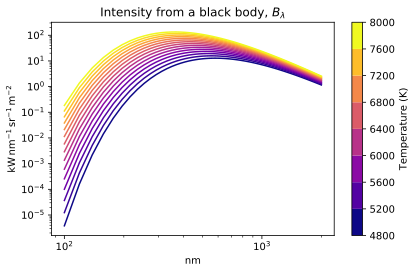

In [3]:
from cycler import cycler
from matplotlib import cm #colormap

i_units = "kW m-2 sr-1 nm-1" #more practical SI units

wave = np.linspace(100,2000,100) * units.nm
temp = np.linspace(5000,8000,15) * units.K
radiation = BlackBody(temp, scale=1.*units.Unit(i_units))(wave[:,np.newaxis])
fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0,1,len(temp)))) #going to go through the whole cm
ax.set_prop_cycle(custom_cycler) #change default colours of plots
ax.set_title(r'Intensity from a black body, $B_\lambda$')
bar = plt.contourf(radiation/radiation*temp, colors = cm.plasma(np.linspace(0,1,8)))
fig.colorbar(bar).set_label("Temperature (K)")
ax.loglog(wave, radiation.to('kW m-2 nm-1 sr-1'));
plt.tight_layout(h_pad=1);

Here, we see the Planck function plotted as a function of wavelengths over a range of temperatures between 5000 and 8000 K. We see that the total intensity and peaks are dependent of temperature. A higher temperature gives more intensity and shifts the intensity peak to smaller wavelengths. We see the different curves tend towards to the left of the plot. This comes from the behaviour of the exponential term in Planck's law for large wavelengths. In this limit the exponential term can be approximated to the Rayleigh-Jeans law,
\begin{equation} 
   B_\lambda(T) = \frac{2c k_\text{B}T}{\lambda^4} \,.
  \label{eq:JR}
\end{equation}
This law only has a linear dependence of temperature, while being suppressed by the $1/\lambda^4$ term. In the logarithmic plot, the intensity should therefore decline linearly like $-4\lambda$. For small wavelengths, the temperature exponentially suppresses the radiation from the black body.

When we observe radiation from a medium, we have to account for background-radiation passing through the medium, and radiation coming from the medium itself. If we assume the medium to be an isothermal black body, the total emergent intensity is 
\begin{equation} 
   I_\lambda = I_\lambda(0) \mathrm{e}^{-\tau} 
        + B_\lambda \, \left( 1 - \mathrm{e}^{-\tau} \right)\,,
  \label{eq:ISO}
\end{equation}
where $I_\lambda(0)$ is the intensity of a beam radiating into the medium from the background.
We can watch how the isothermal black body looks like with different intensity beams coming from the background by plotting the intensity through the medium for different $I_\lambda(0)$. Implementing a function for equation \eqref{eq:ISO}, we plot the intensity against the optical depth of the medium.

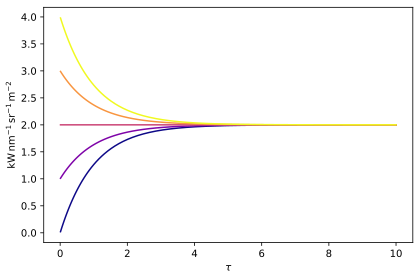

In [4]:
def isothermal_intensity(I0, tau, b_lambda):
    return I0*np.exp(-tau) + b_lambda*(1 - np.exp(-tau))

tau = np.logspace(-2, 1, 100)
i0 = np.arange(5)
b_lambda = 2

I_slab = isothermal_intensity(i0, tau[:,np.newaxis], b_lambda)*units.Unit(i_units)
    
fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0,1,len(i0)))) #going to go through the whole cm
ax.set_prop_cycle(custom_cycler) #change default colours of plots
ax.set_xlabel(r'$\tau$')
ax.plot(tau, I_slab)
plt.tight_layout(h_pad=1);

We can see that the emergent intensity reaches the source function $B_\lambda$ of the black body when it is optically thick. To better see the different regimes of optical depth, we logarithmically visualize the quantities.

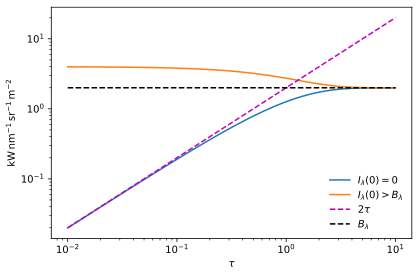

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau$')
ax.loglog(tau, I_slab[:,0], tau, I_slab[:, -1])
ax.loglog(tau, 2*tau, ls = "--", color='m')
ax.loglog(tau, b_lambda*np.ones(len(tau)), ls = "--", color='k')
plt.legend([r"$I_\lambda(0) = 0$", r"$I_\lambda(0) > B_\lambda$", r"$2\tau$", r"$B_\lambda$"])
plt.tight_layout(h_pad=1);

In this plot, we see two different regimes for $\tau$. First we will study $\tau \ll 1$. For initial beam intensity $I_\lambda(0) = 0$, we see a linear incline in the logplot. In this regime, the intensity increases exponentially like $\exp(\tau)$. When $I_\lambda(0) > B_\lambda$, the incoming intensity is almost constant. Therefore it is almost no extinction. A layer with $\tau \ll 1$ is called optically thin because almost all radiation passes throuhg it. Therefore, one could call it radiatively thin.

In the regime $\tau \gg 1$, we see that the emergent intensity of the black body is equal to its source function. No radiation passes through the medium, and all observed radiaton comes from the black body. Therefore we call layers with $\tau \gg 1$ optically thick. We see that the different curves converge quickly towards $B_\lambda$, and are practically constant and independent of $\tau$. In physical terms, this means that all incoming radiation is absorbed by the medium after 

We can use a Schuster-Schwarzchild model to approximate the radiation from a layer around a blackbody like the sun. For this, we use the equation
\begin{equation}
I_{\lambda} = B_{\lambda} e^{- \tau_0} + B_{\lambda} (1 - e^{- \tau})
\end{equation}

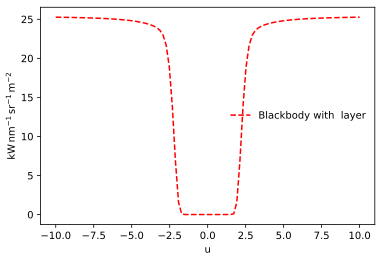

In [6]:
def voigt(damping, u):
    """
    Calculates the Voigt function.
    """
    z = (u + 1j * damping)
    return wofz(z).real

i_units = "kW m-2 sr-1 nm-1" #more practical SI units

temp_surface = 5770 * units.K
temp_layer = 2000 * units.K
tau0 = 10 ** 2
lam_0 = 450 * units.nm
a = 0.01

u = np.linspace(-10, 10, 100)

tau = tau0 * voigt(a, u)
I = lambda tau, wave: BlackBody(temp_surface, scale=1.*units.Unit(i_units))(wave) * np.exp(- tau) \
  + BlackBody(temp_layer, scale=1.*units.Unit(i_units))(wave) * (1 - np.exp(- tau))

plt.figure()
plt.plot(u, I(tau, lam_0), "r--")
plt.xlabel("u")
plt.legend(["Blackbody with  layer"]);

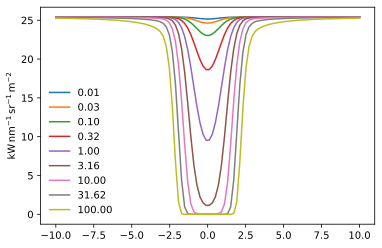

In [7]:
#temp_surface = 5770 * units.K
#temp_layer = 55000 * units.K
#a = 0.5

tau0 = 10 ** np.linspace(-2, 2, 9)
tau = tau0[:, np.newaxis] * voigt(a, u)

leg = []
plt.figure()
for i in range(len(tau)):
    plt.plot(u, I(tau[i], lam_0))
    leg.append("%.2f"%tau0[i])
plt.legend(leg);

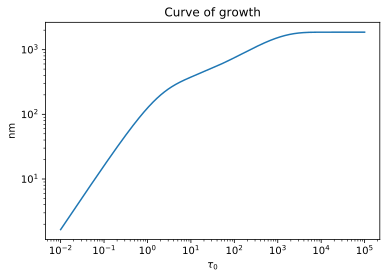

In [8]:
from numpy import trapz

def W_lambda(tau, wave):
    I_lambda = I(tau, wave)
    I_cont = BlackBody(temp_surface, scale=1.*units.Unit(i_units))(wave)
    return trapz((1 - I_lambda/I_cont) , wave)

tau0 = 10 ** np.linspace(-2, 5, 1000)
tau = tau0[:, np.newaxis] * voigt(0.1, u)

wave = np.linspace(100,2000,100) * units.nm
W_lambda(tau, wave)

fig, ax = plt.subplots()
ax.loglog(tau0, W_lambda(tau, wave))
#ax.loglog(tau0, 60*tau0**(1/3))
ax.set_xlabel(r"$\tau_0$")
ax.set_title("Curve of growth");
